## Dataset

In [1]:
import random

import numpy as np
import skimage.transform as transform
from skimage.io import imread


class Reader:
    def __init__(self, image_list, labels_list=[], scale=1):
        assert isinstance(scale, int)
        if len(labels_list) is not 0:
            assert len(image_list) == len(labels_list)

        self.scale = scale

        self.images = image_list
        self.labels = labels_list

        self.train_probabilities = np.ones(len(image_list)) / float(len(image_list))

        self.cache = {}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        if idx not in self.cache:
            rgb = imread(self.images[idx], plugin='pil')
            rgb = transform.resize(rgb, np.array(rgb.shape[:2]) / self.scale,   mode='constant')

            label = None
            if idx < len(self.labels):
                # skimage.io.imread(fname, as_gray=False, plugin=None, **plugin_args)
                label = imread(self.labels[idx], True, plugin='pil')  # False -> 원본 3채널 이미지로
                label = np.digitize(label,bins=np.unique(label))-1
                label = label[::self.scale, ::self.scale]
                label = label[:rgb.shape[0], :rgb.shape[1]]

            self.cache[idx] = (rgb.astype(np.float32), label.astype(np.int32))

        return self.cache[idx]

    
    def create_batch_generator(self, batch_size=3, transforms=[]):
        assert len(self.images) == len(self.labels)

        def f():
            images = []
            labels = []

            for t in transforms:
                if hasattr(t, 'prepare'):
                    t.prepare()

            for index in range(batch_size):
                idx = np.random.choice(range(len(self.images)), 1, p=self.train_probabilities)[0]
                i, l = self[idx]

                for t in transforms:
                    seed = random.randint(0, 2 ** 32 - 1)
                    np.random.seed(seed)
                    i = t(i, True)
                    np.random.seed(seed)
                    l = t(l)

                images.append(np.expand_dims(i.transpose(2, 0, 1), 0))
                labels.append(np.expand_dims(l, 0))

            labels = np.vstack(labels)

            return np.vstack(images).astype(np.float32), labels.astype(np.int32)

        return f

## Network

In [2]:
import math

import torch
import torch.nn as nn


def clip_align(x, y):
    deltax = (y.size(2) - x.size(2)) / 2
    deltay = (y.size(3) - x.size(3)) / 2

    if deltax > 0 and deltay > 0:
        y = y[:, :, deltax:-deltax, deltay:-deltay]
    return y

In [3]:
class DownModule(nn.Module):
    """
    Downscale module
    """
    def __init__(self, in_dims, out_dims, repeats=1, padding=0, non_linearity=nn.ELU, use_dropout=False, use_bn=False):
        super(DownModule, self).__init__()
        layers = [nn.Conv2d(in_dims, out_dims, 3, padding=padding), non_linearity(inplace=True)]

        for i in range(repeats):
            layers += [nn.Conv2d(out_dims, out_dims, 3, padding=padding)]
            if use_bn:
                layers += [nn.BatchNorm2d(out_dims)]
            layers += [non_linearity(inplace=True)]

        if use_dropout:
            layers += [nn.Dropout2d(p=0.1)]

        self.convs = nn.Sequential(*layers)
        self.pool = nn.MaxPool2d(2, 2)
        self.non_ln = non_linearity(inplace=True)

    def forward(self, x):
        return self.pool(self.convs(x))
    
    
class UpModule(nn.Module):
    """
    Upscale module
    """
    def __init__(self, in_dims, out_dims, repeats=1, padding=0, non_linearity=nn.ELU):
        super(UpModule, self).__init__()
        self.conv = nn.ConvTranspose2d(in_dims, out_dims, 2, stride=2)
        layers = [nn.Conv2d(2 * out_dims, out_dims, 3, padding=padding), non_linearity(inplace=True)]
        for i in range(repeats):
            layers += [nn.Conv2d(out_dims, out_dims, 3, padding=padding), non_linearity(inplace=True)]

        self.normconv = nn.Sequential(*[nn.Conv2d(out_dims, out_dims, 2, padding=padding), non_linearity(inplace=True)])
        self.convs = nn.Sequential(*layers)

    def forward(self, x, y):

        x = self.conv(x)

        if 1 == y.size(2) % 2:
            y = self.normconv(y)

        y = clip_align(x, y)

        x = torch.cat([x, y], dim=1)
        
        return self.convs(x)

In [4]:
class EUnet(nn.Module):
    """
    Deep neural network with skip connections
    """
    def __init__(self, in_dims, out_dims, k=1, s=1, l=1, depth=3, base=8, init_xavier=False, padding=0,
                 non_linearity=nn.ReLU, use_dropout=False, use_bn=False):
        """
        Creates a u-net network
        :param in_dims: input image number of channels
        :param out_dims: number of feature maps
        :param k: width coefficient
        :param s: number of repeats in encoder part
        :param l: number of repeats in decoder part
        """
        super(EUnet, self).__init__()
        self.conv = nn.Conv2d(in_dims, base * k, 3, padding=padding)

        self.depth = depth
        self.down = []
        self.up = []

        for i in range(self.depth):
            dn = DownModule(base * (2 ** i) * k, base * (2 ** (i + 1)) * k, s, non_linearity=non_linearity,
                            padding=padding, use_dropout=use_dropout, use_bn=use_bn)
            up = UpModule(base * (2 ** (i + 1)) * k, base * (2 ** i) * k, l, non_linearity=non_linearity,
                          padding=padding)
            self.add_module("Down" + str(i), dn)
            self.add_module("Up" + str(i), up)
            self.down.append(dn)
            self.up.append(up)

        self.conv1x1 = nn.Conv2d(8 * k, out_dims, 1, padding=0)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if init_xavier:
                    torch.nn.init.xavier_uniform_(m.weight)
                else:
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        inter = [self.conv(x)]
        for i in range(self.depth):
            dn = self.down[i](inter[i])
            inter.append(dn)

        up = inter[-1]
        for i in range(1, self.depth + 1):
            m = self.up[self.depth - i]
            up = m(up, inter[-i - 1])

        return self.conv1x1(up)

## Halo Loss

In [5]:
import warnings

import numpy as np
import torch
import torch.nn.functional as F

# http://devdoc.net/python/scikit-image-doc-0.13.1/api/skimage.draw.html#skimage.draw.circle
# from skimage.draw import circle  0.16.2
# from skimage.draw import circle_perimeter  # 0.19.2

In [6]:
# Same as from skimage.draw import circle  0.16.2
# https://github.com/scikit-image/scikit-image/blob/v0.13.1/skimage/draw/draw.py#L144
def _ellipse_in_shape(shape, center, radii, rotation=0.):
    r_lim, c_lim = np.ogrid[0:float(shape[0]), 0:float(shape[1])]
    r_org, c_org = center
    r_rad, c_rad = radii
    rotation %= np.pi
    sin_alpha, cos_alpha = np.sin(rotation), np.cos(rotation)
    r, c = (r_lim - r_org), (c_lim - c_org)
    distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \
                + ((r * sin_alpha - c * cos_alpha) / c_rad) ** 2
    return np.nonzero(distances < 1)


def ellipse(r, c, r_radius, c_radius, shape=None, rotation=0.):

    center = np.array([r, c])
    radii = np.array([r_radius, c_radius])
    # allow just rotation with in range +/- 180 degree
    rotation %= np.pi

    # compute rotated radii by given rotation
    r_radius_rot = abs(r_radius * np.cos(rotation)) \
                   + c_radius * np.sin(rotation)
    c_radius_rot = r_radius * np.sin(rotation) \
                   + abs(c_radius * np.cos(rotation))
    # The upper_left and lower_right corners of the smallest rectangle
    # containing the ellipse.
    radii_rot = np.array([r_radius_rot, c_radius_rot])
    upper_left = np.ceil(center - radii_rot).astype(int)
    lower_right = np.floor(center + radii_rot).astype(int)

    if shape is not None:
        # Constrain upper_left and lower_right by shape boundary.
        upper_left = np.maximum(upper_left, np.array([0, 0]))
        lower_right = np.minimum(lower_right, np.array(shape[:2]) - 1)

    shifted_center = center - upper_left
    bounding_shape = lower_right - upper_left + 1

    rr, cc = _ellipse_in_shape(bounding_shape, shifted_center, radii, rotation)
    rr.flags.writeable = True
    cc.flags.writeable = True
    rr += upper_left[0]
    cc += upper_left[1]
    return rr, cc


def circle(r, c, radius, shape=None):
    return ellipse(r, c, radius, radius, shape)

In [7]:
def flatten(x):
    return x.view(x.size(0), -1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def build_halo_mask(fixed_depth=30, margin=21, min_fragment=10):
    """
    Function builds a configuration for halo region building
    :param fixed_depth: Maximum object on an image
    :param margin: The size of halo region
    :param min_fragment: Minimal size of an object on the image
    :return: a function for generation labels, masks and object_lists used by halo loss
    """
    assert margin % 2 is not 0, "Margin should be odd"

    rr, cc = circle(margin / 2, margin / 2, margin / 2 + 1, shape=(margin, margin))
    structure_element = numpy.zeros((margin, margin))
    structure_element[rr, cc] = 1
    structure_element = numpy.repeat(numpy.expand_dims(numpy.expand_dims(structure_element, 0), 0), fixed_depth, 0)

    sel = torch.from_numpy(structure_element).float().to(device)

    def f(label):
        """
        
        :param label: batch of instance levels each instance must have unique id
        :return:  labels, masks and object_lists used by halo loss
        """
        back = numpy.zeros((label.shape[0], fixed_depth, label.shape[1], label.shape[2]))
        object_list = []
        for i in range(label.shape[0]):
            bincount = numpy.bincount(label[i].flatten())
            pixels = numpy.where(bincount > min_fragment)[0]
            if len(pixels) > fixed_depth:
                pixels = pixels[:fixed_depth]
                warnings.warn("Not all objects fits in fixed depth", RuntimeWarning)

            for l, v in enumerate(pixels):
                back[i, l, label[i] == v] = 1.
            object_list.append(numpy.array(range(l + 1)))

        labels = torch.from_numpy(back).float().to(device)
        masks = F.conv2d(labels, sel, groups=fixed_depth, padding='same')
        
        masks[masks > 0] = 1.
        masks[labels > 0] = 2.
        masks[:, 0, :, :] = 1.
        
        weights=masks.sum(-1,keepdim=True).sum(-2,keepdim=True)
        weights[weights==0.]=1.
        
        masks = masks/weights
        
        return labels, masks, object_list

    return f

In [8]:
def halo_loss(predicted, labels, weights, obj, k_neg=7.):
    """
    Loss that seeks the best split of instances to several channels
    :param predicted: tensor output from neural network(NxCxWxH)
    :param labels: ground truth binary mask for each object
    :param weights: weights for each object and it's margin
    :param obj: list for each sample indexes of labels, containing any meaningful information
    :param k_neg: negative positioning influance 
    :return: torch variable contains calculation graph
    """

    global_loss = torch.FloatTensor([0]).to(device)
    x_lsm = F.log_softmax(predicted, dim=1)
    x_sm = F.softmax(predicted, dim=1)

    v_weights = weights
    v_labels = labels

    for i in range(predicted.size(0)):  # Foreach sample

        # predicted[0] is preserved for background
        bg = v_weights[i, 0] * v_labels[i, 0]
        global_loss += -torch.sum(bg * x_lsm[i, 0]) / torch.sum(bg)

        if 0 == len(obj[i][1:]):
            continue

        indexes = torch.LongTensor(obj[i][1:]).to(device)  # One is for labels

        valid_labels = v_labels[i].index_select(0, indexes)
        valid_weights = v_weights[i].index_select(0, indexes)

        target_pos = valid_labels * valid_weights
        target_neg = (1. - valid_labels) * valid_weights

        positive = -torch.mm(flatten(x_lsm[i, 1:]),
                             flatten(target_pos).transpose(1, 0)) / torch.sum(target_pos)

        negative = -torch.mm(flatten(torch.log(1. - x_sm[i, 1:] + 1e-12)),
                             flatten(target_neg).transpose(1, 0)) / torch.sum(target_neg)

        values, indices = torch.min(positive + k_neg * negative, 0)
        global_loss += torch.sum(positive[indices, torch.arange(0, positive.size(1)).long().to(device)])

    # Normalize w.r.t. image size
    return global_loss * (1000. / (predicted.size(2) * predicted.size(3)))

## Train

In [9]:
import sys

import numpy
import torch

from copy import deepcopy
#from halo_loss import halo_loss


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(generator, model, mask_builder,
          niter=4000,
          lr=1e-3,
          caption="E:/DeepColoring",
          k_neg=7,
          verbose=True):

    def print_percent(percent):
        sys.stdout.write('\r')
        sys.stdout.write("[%-20s] %d%%" % ('=' * percent, 5 * percent))
        sys.stdout.flush()
    
    model.train()

    errors = []
    lowest_loss = 100
    
    percent_old = 0
    if verbose:
        print_percent(percent_old)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for i in range(niter):
        x, y = generator()
        x_t = torch.from_numpy(x).to(device)

        optimizer.zero_grad()

        pred = model(x_t)
        labels, halo, objects = mask_builder(y)
        loss = halo_loss(pred, labels, halo, objects, k_neg=k_neg)
        print('epoch :', i, 'error :', loss.item())

        errors.append(loss.item())
        loss.backward()
        optimizer.step()

        if 0 == i % 1000:
            torch.save(model.state_dict(), caption + f'_epoch{i}_{round(loss.item(), 4)}.t7')
            
        if loss < lowest_loss:
            lowest_loss = loss
            best_model = deepcopy(model.state_dict())
            torch.save(best_model, caption + f'_best.t7')
            print(f'Best Model Updated at epoch{i} with loss {round(loss.item(), 4)}')

        if verbose:
            percent = int(float(i) / float(niter)*20.)
            if percent_old != percent:
                percent_old = percent
                print_percent(percent)

    if verbose:
        print_percent(20)

    torch.save(model.state_dict(), caption + '.t7')
    numpy.savetxt(caption + '.txt', errors, "%5.5f")
    numpy.savetxt(caption + '_best.txt', lowest_loss.cpu(), "%5.5f")
    
    return model, errors

In [10]:
import os
from os import listdir
from os.path import join
import argparse

import numpy
import torch

import random

import numpy as np
import skimage.transform as transform
from skimage.io import imread

basepath = 'E:/CVPPP2017_LSC_training/images/A1'

rgb = sorted([join(basepath, f) for f in listdir(basepath) if f.endswith('_rgb.png')])
labels = sorted([join(basepath, f) for f in listdir(basepath) if f.endswith('_label.png')])

numpy.random.seed(1203412412)
indexes = numpy.random.permutation(len(rgb))
perm_rgb = numpy.array(rgb)[indexes].tolist()
perm_labels = numpy.array(labels)[indexes].tolist()

train_data = Reader(perm_rgb[:-10], perm_labels[:-10], 1)  # (530, 500, 4) / (530, 500)
valid_data = Reader(perm_rgb[-10:], perm_labels[-10:], 1)


import utils as dc

transforms = [dc.rgba2rgb(),
              dc.clip_patch((192, 192)),
              dc.flip_horizontally(),
              dc.flip_vertically(),
              dc.rotate90(),
              #dc.random_transform(0.1, 90, 0),
              dc.blur(),
              dc.normalize(0.5, 0.5)]

train_generator = train_data.create_batch_generator(40, transforms=transforms)  # batch_size

# fixed_depth: pre-define # of colors(instances)
# margin:
mask_builder = build_halo_mask(fixed_depth=30, margin=21, min_fragment=10)  

# in_dims, out_dims, width_coeff=4
# # of encoder repeats=3, # of decoder repeats=1
net = EUnet(3, 9, 4, 3, 1, depth=3, padding=1, init_xavier=True, use_bn=False, use_dropout=True).to(device)

In [11]:
model, errors = train(generator=train_generator,
                         model=net,
                         mask_builder=mask_builder,
                         niter=20001,
                         k_neg=7,
                         lr=1e-3,
                         caption='E:/DeepColoring/ckp')

[                    ] 0%

C:\Users\Moon\Leaf_Segmentation\harmonic\utils.py:108: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = skimage.filters.gaussian(x, sigma=abs(sigma + gain_random * numpy.random.randn()),preserve_range=True,multichannel=True)


epoch : 0 error : 0.08854842931032181
Best Model Updated at epoch0 with loss 0.0885
epoch : 1 error : 0.08174674212932587
Best Model Updated at epoch1 with loss 0.0817
epoch : 2 error : 0.07423770427703857
Best Model Updated at epoch2 with loss 0.0742
epoch : 3 error : 0.05035640299320221
Best Model Updated at epoch3 with loss 0.0504
epoch : 4 error : 0.05973513796925545
epoch : 5 error : 0.056494373828172684
epoch : 6 error : 0.0472659133374691
Best Model Updated at epoch6 with loss 0.0473
epoch : 7 error : 0.037162814289331436
Best Model Updated at epoch7 with loss 0.0372
epoch : 8 error : 0.032728955149650574
Best Model Updated at epoch8 with loss 0.0327
epoch : 9 error : 0.030905360355973244
Best Model Updated at epoch9 with loss 0.0309
epoch : 10 error : 0.031665682792663574
epoch : 11 error : 0.027824683114886284
Best Model Updated at epoch11 with loss 0.0278
epoch : 12 error : 0.03451961278915405
epoch : 13 error : 0.0315047949552536
epoch : 14 error : 0.03712340071797371
epoch 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

## Evaluation

In [12]:
def evaluate(data, model, min_points):
    """
    Estimates the 
    :param data: 
    :param model: 
    :param min_points: 
    :return: 
    """
    assert isinstance(data, Reader)

    res = []
    model.eval()

    for i in range(len(data)):
        x, y = data[i]
        x = dc.rgba2rgb()(x, True)
        x = dc.normalize(0.5, 0.5, )(x, True)
        x = x.transpose(2, 0, 1)[:, :240, :240]

        vx = torch.from_numpy(numpy.expand_dims(x, 0)).to(device)
        p = model(vx)
        p_numpy = p.detach().cpu().numpy()[0]

        ground_truth = dc.get_as_list(y[:240, :240])
        instances = dc.postprocess(p_numpy, min_points)
        detected_masks = dc.get_as_list(instances)
        res.append(dc.symmetric_best_dice(ground_truth, detected_masks))

    return numpy.array(res).mean(axis=0), numpy.array(res).std(axis=0)

In [13]:
print(evaluate(valid_data, net, 40))
print(evaluate(valid_data, net, 65))

(0.3799591770350731, 0.08451765853124991)
(0.43397196941077654, 0.09136588947716243)


## Inference

In [15]:
unet = EUnet(3, 9, 4, 3, 1, depth=3, padding=1, init_xavier=True, use_bn=False, use_dropout=True).to(device)
unet.load_state_dict(torch.load("E:/DeepColoring/ckp_best.t7"))
unet.eval()
print("Model loaded")

Model loaded


(<Figure size 1440x720 with 2 Axes>, <Figure size 1440x720 with 9 Axes>)

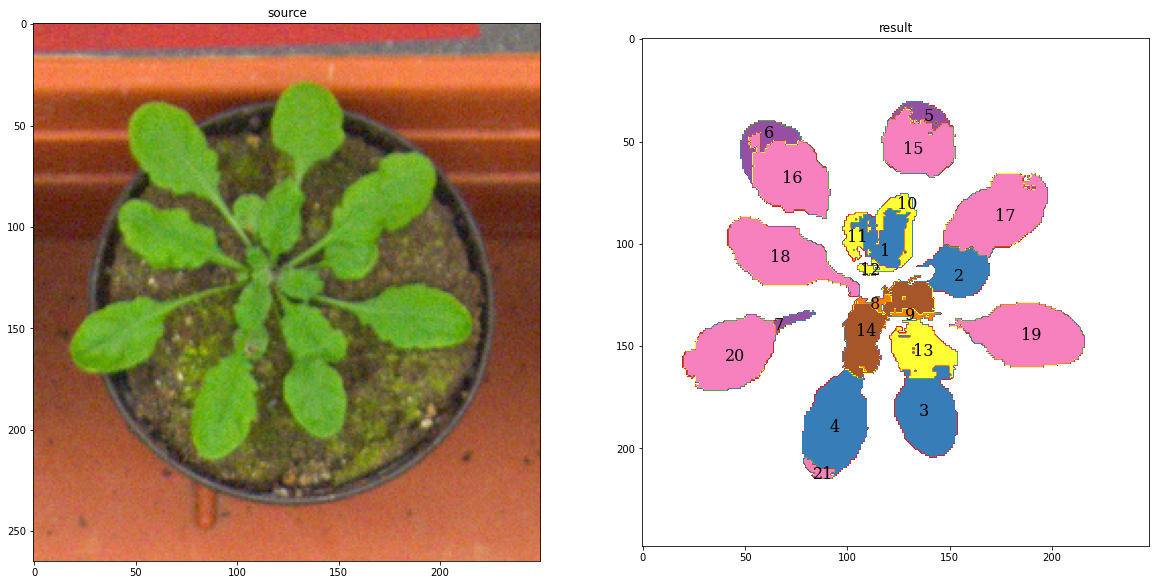

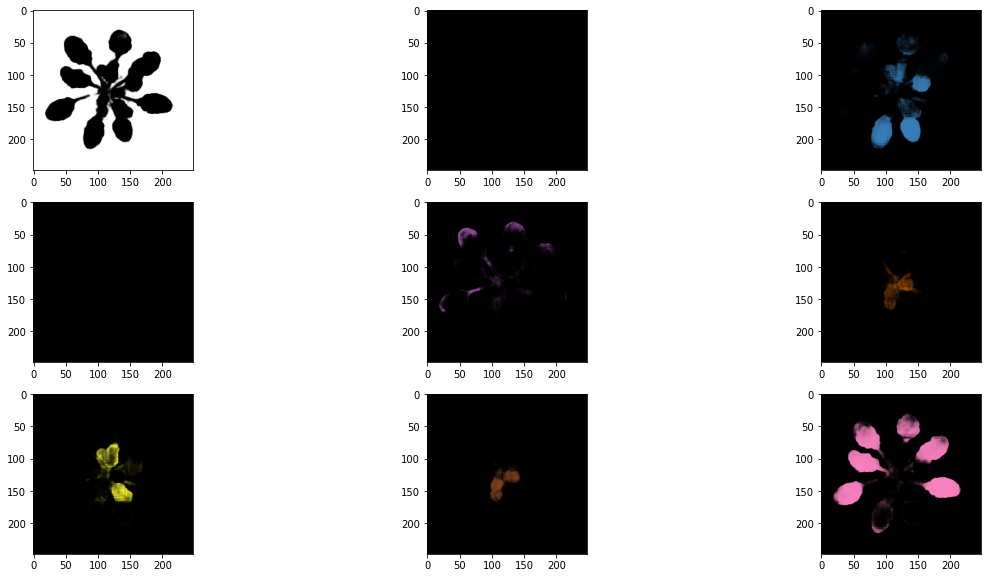

In [18]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from os import listdir
from os.path import join
#from train_cvppp import evaluate

#import deepcoloring as dc

%matplotlib inline
import numpy as np


from skimage.io import imread

xo = imread('E:/CVPPP2017_LSC_training/images/A1/plant121_rgb.png')[::2, ::2]

x = dc.rgba2rgb()(xo, True)/255.
x = dc.normalize(0.5, 0.5, )(x, True)
x = x.transpose(2, 0, 1)[:, :248, :248]

vx = torch.from_numpy(np.expand_dims(x, 0)).to(device)
p = unet(vx)
p_numpy = p.detach().cpu().numpy()[0]

dc.visualize(xo[:,:,:3], p_numpy, 65)